# 01.1 Discrete-Time Formalism

<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**

- Set up a discrete-time financial market on a finite probability space.  
- Define riskless and risky assets, discounted prices, and trading strategies.  
- Introduce self-financing, admissible strategies, and arbitrage.

**The notebook is structured in progressive part**

It first establishes the discrete-time market model and the concept of discounting, then introduces trading strategies and portfolio valuation.  
Next, it formalises the notions of self-financing and arbitrage, before ending with two practical examples:  
one computing portfolio values step by step, and another visualising a binomial price tree.  

This formal framework will serve as the **common base for all subsequent notebooks** in Section 01.


## 1. Discrete-time market model

We work on a finite probability space:
- $(\Omega, \mathcal{F}, \mathbb{P})$,
- with a filtration $(\mathcal{F}_n)_{0 \le n \le N}$ such that
  $$
  \mathcal{F}_0 \subset \mathcal{F}_1 \subset \dots \subset \mathcal{F}_N \subset \mathcal{F}.
  $$

Here, $\mathcal{F}_n$ represents the information available up to time $n$.

There are $d+1$ assets:
- asset $0$: riskless asset,
- assets $1,\dots,d$: risky assets.

For each $n = 0,\dots,N$:
$$
S_n = (S_n^0, S_n^1, \dots, S_n^d),
$$
where $S_n^i$ is the price of asset $i$ at time $n$, and $S_n^i$ is $\mathcal{F}_n$-measurable.


### 1.1 Riskless asset and discount factor

We normalise:
$$
S_0^0 = 1.
$$

If the per-period riskless rate is $r$, then for all $n$:
$$
S_n^0 = (1 + r)^n.
$$

The **discount factor** is defined by:
$$
\beta_n = \frac{1}{S_n^0} = (1 + r)^{-n}.
$$

Interpretation: investing $\beta_n$ at time 0 in the riskless asset yields 1 at time $n$.


### 1.2 Discounted prices

We define the vector of discounted prices:
$$
\tilde{S}_n = \big(1, \, \beta_n S_n^1, \dots, \beta_n S_n^d \big).
$$

The riskless asset becomes the numéraire (unit of account): all risky prices are expressed in units of the riskless asset.

Later, in 1.2, discounted prices $(\tilde{S}_n)$ will be martingales under a risk-neutral measure $\mathbb{P}^*$ when there is no arbitrage.


## 2. Trading strategies

A (predictable) trading strategy is a sequence
$$
\varphi = (\varphi_n)_{0 \le n \le N}, \quad 
\varphi_n = (\varphi_n^0, \dots, \varphi_n^d),
$$
where $\varphi_n^i$ is the number of units of asset $i$ held **during the period $(n, n+1]$**.

Predictability:
- $\varphi_0^i$ is $\mathcal{F}_0$-measurable,
- for $n \ge 1$, $\varphi_n^i$ is $\mathcal{F}_{n-1}$-measurable.

In words: at time $n-1$, using the information $\mathcal{F}_{n-1}$, we decide what we will hold on $(n, n+1]$.


### 2.1 Portfolio value

The portfolio value at time $n$ is:
$$
V_n(\varphi) = \varphi_n \cdot S_n = \sum_{i=0}^d \varphi_n^i S_n^i.
$$

The discounted portfolio value is:
$$
\tilde{V}_n(\varphi) = \beta_n V_n(\varphi) = \varphi_n \cdot \tilde{S}_n.
$$


## 3. Self-financing condition

A strategy is **self-financing** if we never add or withdraw external cash; changes in portfolio value come only from price movements.

**Definition.**  
A strategy $\varphi$ is self-financing if, for all $n$:
$$
\varphi_n \cdot S_n = \varphi_{n+1} \cdot S_n.
$$

Interpretation:
- At time $n$, prices $S_n$ are observed.
- We rebalance from $\varphi_n$ to $\varphi_{n+1}$.
- The value during the rebalancing stays the same: we only reshuffle between assets.

Equivalent form:
$$
V_{n+1}(\varphi) - V_n(\varphi) = \varphi_{n+1} \cdot (S_{n+1} - S_n).
$$

In discounted form:
$$
\tilde{V}_n(\varphi)
= \tilde{V}_0(\varphi)
+ \sum_{j=1}^n \varphi_j \cdot \Delta \tilde{S}_j,
\quad \Delta \tilde{S}_j = \tilde{S}_j - \tilde{S}_{j-1}.
$$


## 4. Admissible strategies and arbitrage

Signs:
- $\varphi_n^i > 0$: long position in asset $i$,
- $\varphi_n^i < 0$: short position in asset $i$ (or borrowing if $i = 0$).

### 4.1 Admissible strategy

A strategy $\varphi$ is **admissible** if:
- it is self-financing, and
- for all $n = 0,\dots,N$:
    $$
    V_n(\varphi) \ge 0.
    $$

So the portfolio value is never negative (we can always repay).

### 4.2 Arbitrage

An **arbitrage strategy** is an admissible strategy $\varphi$ such that:
- $V_0(\varphi) = 0$,
- $V_N(\varphi) \ge 0$ almost surely,
- $\mathbb{P}\big( V_N(\varphi) > 0 \big) > 0$.

This represents "free money": we start with zero capital, we never go below zero, and we have a strictly positive probability to end strictly positive.

Later, 1.2 will show:
> "No arbitrage" ⇔ ∃ a measure $\mathbb{P}^*$ equivalent to $\mathbb{P}$ such that **discounted prices** $(\tilde{S}_n)$ are martingales under $\mathbb{P}^*$.


## 5. Python implemented example consistent with the theory

Just to anchor the formalism, a tiny binomial market with 1 risky + 1 riskless asset over $N = 2$.


### 5.1 Build risky asset tree and riskless asset

In [1]:
import numpy as np
import pandas as pd

# Parameters
N = 2
S0_1 = 100.0     # initial risky asset price S_0^1
r = 0.05         # riskless rate per period
u = 1.2          # up factor
d = 0.8          # down factor

def riskless_price(n):
    return (1 + r) ** n

# Build binomial tree for S_n^1
paths = []

def build_paths(s, n, current):
    if n == N:
        paths.append(current + [s])
    else:
        build_paths(s * u, n + 1, current + [s])
        build_paths(s * d, n + 1, current + [s])

build_paths(S0_1, 0, [])
S1_tree = pd.DataFrame(paths).T  # rows: n=0..N, cols: scenarios
S1_tree.index = [f"n={n}" for n in range(N + 1)]
S1_tree.columns = [f"ω{i+1}" for i in range(S1_tree.shape[1])]

S1_tree


,ω1,ω2,ω3,ω4
n=0,100.0,100.0,100.0,100.0
n=1,120.0,120.0,80.0,80.0
n=2,144.0,96.0,96.0,64.0


### 5.2 Discounted risky prices

In [2]:
# Discount factors β_n
beta = np.array([(1 + r) ** (-n) for n in range(N + 1)])
beta

array([1.        , 0.95238095, 0.90702948])

In [3]:
# Discounted risky prices: β_n S_n^1
tilde_S1_tree = S1_tree.mul(beta.reshape(-1, 1))
tilde_S1_tree

,ω1,ω2,ω3,ω4
n=0,100.000000,100.000000,100.000000,100.000000
n=1,114.285714,114.285714,76.190476,76.190476
n=2,130.612245,87.074830,87.074830,58.049887


### 5.3 Define a simple (constant) strategy and compute portfolio value

We consider:
- asset 0: riskless,
- asset 1: risky.

Take a simple strategy: hold 1 risky share and choose the riskless position so that $V_0 = 0$.


In [4]:
# Define a simple strategy φ: (φ_n^0, φ_n^1) constant over n
phi_1 = 1.0  # one unit of risky asset at all times

S0_0 = riskless_price(0)
phi_0 = - phi_1 * S0_1 / S0_0   # choose φ_0^0 so that V_0 = 0

phi = {
    0: np.array([phi_0, phi_1]),
    1: np.array([phi_0, phi_1]),
    2: np.array([phi_0, phi_1]),
}
phi


{0: array([-100.,    1.]), 1: array([-100.,    1.]), 2: array([-100.,    1.])}

We compute $V_n(\varphi)$ and $\tilde{V}_n(\varphi)$:


In [5]:
def portfolio_values(phi, S1_tree):
    """
    phi: dict n -> np.array([φ_n^0, φ_n^1])
    S1_tree: DataFrame of S_n^1 across scenarios
    """
    scenarios = S1_tree.columns
    V = pd.DataFrame(index=S1_tree.index, columns=scenarios, dtype=float)
    V_tilde = pd.DataFrame(index=S1_tree.index, columns=scenarios, dtype=float)
    
    for n_label in S1_tree.index:
        n = int(n_label.split('=')[1])
        S0_n = riskless_price(n)
        S1_n = S1_tree.loc[n_label].values  # shape (num_scenarios,)
        phi_n = phi[n]
        
        # S_n = (S_n^0, S_n^1)
        V_n = phi_n[0] * S0_n + phi_n[1] * S1_n
        V.loc[n_label] = V_n
        
        beta_n = (1 + r) ** (-n)
        V_tilde.loc[n_label] = beta_n * V_n
    
    return V, V_tilde

V_tree, V_tilde_tree = portfolio_values(phi, S1_tree)
V_tree, V_tilde_tree


(        ω1     ω2     ω3     ω4
 n=0   0.00   0.00   0.00   0.00
 n=1  15.00  15.00 -25.00 -25.00
 n=2  33.75 -14.25 -14.25 -46.25,
             ω1         ω2         ω3         ω4
 n=0   0.000000   0.000000   0.000000   0.000000
 n=1  14.285714  14.285714 -23.809524 -23.809524
 n=2  30.612245 -12.925170 -12.925170 -41.950113)

## 6. Illustrative binomial price tree model

To make the formalism concrete, we consider:
- one riskless asset $S_n^0 = (1+r)^n$,
- one risky asset $S_n^1$ following a binomial tree with up/down factors.

We build all possible paths of $S_n^1$ on a horizon $N = 3$ and visualize the tree.


Building :

In [6]:
import matplotlib.pyplot as plt

# Parameters
N = 3          # number of steps
S0_1 = 100.0   # initial risky price S_0^1
r = 0.05       # riskless rate per period
u = 1.2        # up factor
d = 0.8        # down factor

# Build all possible paths for S_n^1 in a binomial model
paths = []

def build_paths(s, n, current):
    if n == N:
        paths.append(current + [s])
    else:
        build_paths(s * u, n + 1, current + [s])
        build_paths(s * d, n + 1, current + [s])

build_paths(S0_1, 0, [])
S1_tree = pd.DataFrame(paths).T   # rows = n, cols = scenarios
S1_tree.index = [f"n={n}" for n in range(N + 1)]
S1_tree.columns = [f"ω{i+1}" for i in range(S1_tree.shape[1])]

S1_tree


,ω1,ω2,ω3,ω4,ω5,ω6,ω7,ω8
n=0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
n=1,120.0,120.0,120.0,120.0,80.0,80.0,80.0,80.0
n=2,144.0,144.0,96.0,96.0,96.0,96.0,64.0,64.0
n=3,172.8,115.2,115.2,76.8,115.2,76.8,76.8,51.2


Visualizing  :

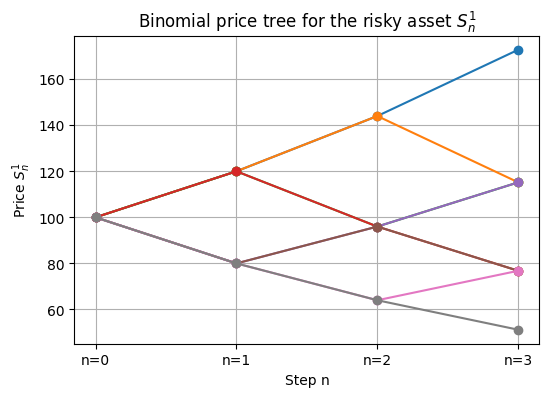

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(S1_tree, marker='o')
plt.title("Binomial price tree for the risky asset $S_n^1$")
plt.xlabel("Step n")
plt.ylabel("Price $S_n^1$")
plt.grid(True)
plt.show()